<a href="https://colab.research.google.com/github/UdayG01/looks.ai/blob/main/gemini_multi_modal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal LLM using Google's Gemini model for image understanding and build Retrieval Augmented Generation with LlamaIndex

In this notebook, we show how to use Google's Gemini Vision models for image understanding.

First, we show several functions we are now supporting for Gemini:
* `complete`: for a single prompt and list of images
* `stream complete` : for steaming output of complete

For the 2nd part of this notebook, we try to use `Gemini` + `Pydantic` to parse structured information for images from Google Maps.
* Define the desired Pydantic class with attribution fields
* Let `gemini-pro-vision` model understand each image and output structured results

For the 3rd part of this notebook, we propose using Gemini & LlamaIndex to build a simple `Retrieval Augmented Generation` Flow for a small Google Maps restaurant dataset.
* Build vector index based on the structured outputs from Step 2
* Using the `gemini-pro` model to synthesize the results and recommends restaurants based on user query.

Note: `google-generativeai` is only available for certain countries and regions.

In [ ]:
! pip install -q llama-index-multi-modal-llms-gemini
! pip install -q llama-index-vector-stores-qdrant
! pip install -q llama-index-embeddings-gemini
! pip install -q llama-index-llms-gemini

In [ ]:
!pip install -q llama-index 'google-generativeai>=0.3.0' matplotlib qdrant_client

##  Use Gemini to understand Images from URLs

In [ ]:
%env GEMINI_API_KEY=...

env: GEMINI_API_KEY=...


In [ ]:
import os
from google.colab import userdata


GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')  # add your GOOGLE API key here
os.environ["GEMINI_API_KEY"] = GEMINI_API_KEY

## Initialize `GeminiMultiModal` and Load Images from URLs

In [ ]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal

from llama_index.core.multi_modal_llms.generic_utils import load_image_urls

image_urls = [
    "https://storage.googleapis.com/generativeai-downloads/data/scene.jpg",
    # Add yours here!
]

image_documents = load_image_urls(image_urls)

In [ ]:
gemini_pro = GeminiMultiModal(model_name="models/gemini-1.5-flash", api_key=GEMINI_API_KEY, max_new_tokens=1500)

https://storage.googleapis.com/generativeai-downloads/data/scene.jpg


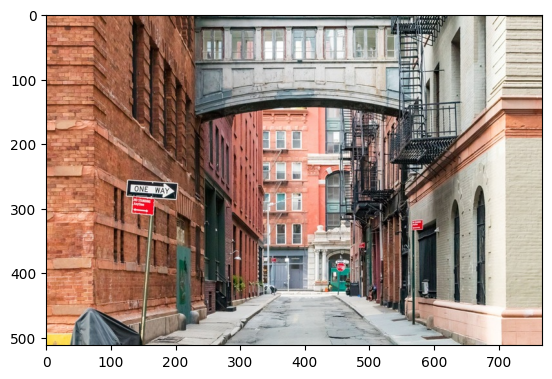

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

img_response = requests.get(image_urls[0])
print(image_urls[0])
img = Image.open(BytesIO(img_response.content))
plt.imshow(img)

### Complete a prompt with a bunch of images

In [ ]:
complete_response = gemini_pro.complete(
    prompt="Identify the city where this photo was taken.",
    image_documents=image_documents,
)

In [ ]:
print(complete_response)

New York City.


### Steam Complete a prompt with a bunch of images

In [ ]:
stream_complete_response = gemini_pro.stream_complete(
    prompt="Give me more context for this image",
    image_documents=image_documents,
)

In [ ]:
for r in stream_complete_response:
    print(r.text, end="")

The image shows a narrow street in a city, with brick buildings on either side. There is a pedestrian bridge overhead, and a "one way" sign on the left side of the street. The street is empty, and the buildings are old and worn. The image is likely taken in a historic district of a city, such as New York City or Boston. The image evokes a sense of urban decay and neglect, but also a certain charm and character. The buildings are tall and narrow, with many windows, and the street is lined with fire escapes. The image is a good example of urban photography, and it captures the unique atmosphere of a city street.

### Compare images

https://res.cloudinary.com/hello-tickets/image/upload/c_limit,f_auto,q_auto,w_1920/v1640835927/o3pfl41q7m5bj8jardk0.jpg


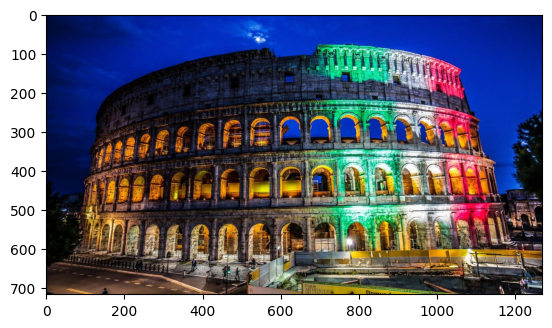

In [ ]:
image_urls = [
    "https://media.ahmedabadmirror.com/am/uploads/mediaGallery/image/1632829935626.jpg-org",
    "https://res.cloudinary.com/hello-tickets/image/upload/c_limit,f_auto,q_auto,w_1920/v1640835927/o3pfl41q7m5bj8jardk0.jpg",
    "https://i.pinimg.com/564x/75/10/a2/7510a2b625b9d40531c13d7a07156f15.jpg",
]

image_documents_1 = load_image_urls(image_urls)

# img_response = requests.get(image_urls[1])
# print(image_urls[1])
# img = Image.open(BytesIO(img_response.content))
# plt.imshow(img)

response_multi = gemini_pro.complete(
    prompt="is there any relationship between those images?",
    image_documents=image_documents_1,
)
print(response_multi)

## 2nd Part: `Gemini` + `Pydantic` for Structured Output Parsing from an Image

* Leveraging Gemini for the image reasoning
* Use Pydantic program to generate structured output from the image reasoning results of Gemini

In [ ]:
import google.generativeai as genai

genai.configure(
    api_key=GEMINI_API_KEY,
    client_options={"api_endpoint": "generativelanguage.googleapis.com"},
)

List available Gemini Models from `google.generativeai`.
Make sure your API key has access to belowing models

In [ ]:
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-1.0-pro-latest
models/gemini-1.0-pro
models/gemini-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-pro-exp-0801
models/gemini-1.5-pro-exp-0827
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-exp-0827
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924


### Download example images for Gemini to understand

In [ ]:
from pathlib import Path

input_image_path = Path("google_restaurants")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

In [ ]:
!wget "https://docs.google.com/uc?export=download&id=1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg" -O ./google_restaurants/miami.png
!wget "https://docs.google.com/uc?export=download&id=1dYZy17bD6pSsEyACXx9fRMNx93ok-kTJ" -O ./google_restaurants/orlando.png
!wget "https://docs.google.com/uc?export=download&id=1ShPnYVc1iL_TA1t7ErCFEAHT74-qvMrn" -O ./google_restaurants/sf.png
!wget "https://docs.google.com/uc?export=download&id=1WjISWnatHjwL4z5VD_9o09ORWhRJuYqm" -O ./google_restaurants/toronto.png

--2024-11-09 06:11:39--  https://docs.google.com/uc?export=download&id=1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg
Resolving docs.google.com (docs.google.com)... 74.125.126.100, 74.125.126.138, 74.125.126.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.126.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg&export=download [following]
--2024-11-09 06:11:39--  https://drive.usercontent.google.com/download?id=1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.125.132, 2607:f8b0:4001:c2f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.125.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1800953 (1.7M) [image/png]
Saving to: ‘./google_restaurants/miami.png’

./google_restaurant 100%[===================>]   1.72M  --.-KB/s  

### Define the Pydantic Class for the Structured Parser

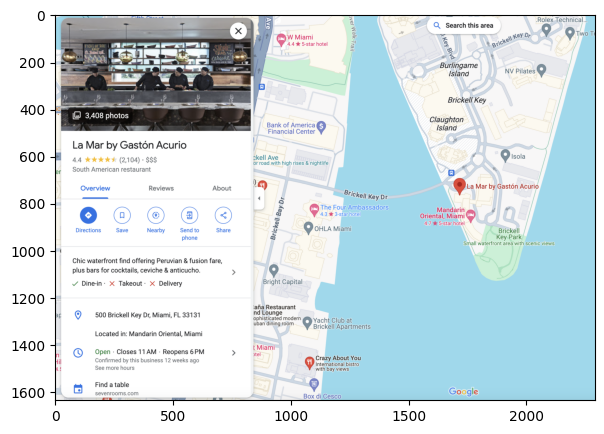

In [ ]:
from pydantic import BaseModel
from PIL import Image
import matplotlib.pyplot as plt
from typing import Optional


class GoogleRestaurant(BaseModel):
    """Data model for a Google Restaurant."""

    restaurant: str
    food: str
    location: str
    category: str
    hours: str
    price: str
    rating: float
    review: str
    description: str
    nearby_tourist_places: Optional[str]


google_image_url = "./google_restaurants/miami.png"
image = Image.open(google_image_url).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

### Call the Pydantic Program and Generate Structured Output

In [ ]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser

prompt_template_str = """\
    can you summarize what is in the image\
    and return the answer with json format \
"""


def pydantic_gemini(
    model_name, output_class, image_documents, prompt_template_str
):
    gemini_llm = GeminiMultiModal(
        api_key=GEMINI_API_KEY, model_name=model_name
    )

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    return response

### Generate the Pydantic Structured Output via Gemini Vision Model

In [ ]:
from llama_index.core import SimpleDirectoryReader

google_image_documents = SimpleDirectoryReader(
    "./google_restaurants"
).load_data()

results = []
for img_doc in google_image_documents:
    pydantic_response = pydantic_gemini(
        "models/gemini-1.5-pro-latest",
        GoogleRestaurant,
        [img_doc],
        prompt_template_str,
    )
    # only output the results for miami for example along with image
    if "miami" in img_doc.image_path:
        for r in pydantic_response:
            print(r)
    results.append(pydantic_response)

> Raw output: ```json
{"restaurant": "La Mar by Gastón Acurio", "food": "Peruvian & fusion fare, cocktails, ceviche & anticucho", "location": "500 Brickell Key Dr, Miami, FL 33131", "category": "South American restaurant", "hours": "Open · Closes 11 AM · Reopens 6PM", "price": "$$$", "rating": 4.4, "review": "(2,104)", "description": "Chic waterfront find offering Peruvian & fusion fare, plus bars for cocktails, ceviche & anticucho.", "nearby_tourist_places": "Brickell Key Park"}
```
('restaurant', 'La Mar by Gastón Acurio')
('food', 'Peruvian & fusion fare, cocktails, ceviche & anticucho')
('location', '500 Brickell Key Dr, Miami, FL 33131')
('category', 'South American restaurant')
('hours', 'Open · Closes 11 AM · Reopens 6PM')
('price', '$$$')
('rating', 4.4)
('review', '(2,104)')
('description', 'Chic waterfront find offering Peruvian & fusion fare, plus bars for cocktails, ceviche & anticucho.')
('nearby_tourist_places', 'Brickell Key Park')
> Raw output: ```json
{"restaurant": "M

`Observation`:
* Gemini perfectly generates all the meta information we need for the Pydantic class
* It could also recognizes the nearby park from `Google Maps`

## 3rd Part: Build Multi-Modal RAG for Restaurant Recommendation

Our stack consists of Gemini + LlamaIndex + Pydantic structured output capabilities

### Construct Text Nodes for Building Vector Store. Store metadata and description for each restaurant.

In [ ]:
from llama_index.core.schema import TextNode

nodes = []
for res in results:
    text_node = TextNode()
    metadata = {}
    for r in res:
        # set description as text of TextNode
        if r[0] == "description":
            text_node.text = r[1]
        else:
            metadata[r[0]] = r[1]
    text_node.metadata = metadata
    nodes.append(text_node)

### Using Gemini Embedding for building Vector Store for Dense retrieval. Index Restaurants as nodes into Vector Store

In [ ]:
! pip install -q llama-index-vector-stores-qdrant llama-index-readers-file llama-index-embeddings-fastembed

In [ ]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.embeddings.gemini import GeminiEmbedding
from llama_index.llms.gemini import Gemini
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import Settings
from llama_index.core import StorageContext
import qdrant_client


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_gemini_4")

vector_store = QdrantVectorStore(client=client, collection_name="collection")

# Using the embedding model to Gemini
Settings.embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GEMINI_API_KEY
)
Settings.llm = Gemini(api_key=GEMINI_API_KEY, model="models/gemini-1.5-pro-latest")

storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    storage_context=storage_context,
)

### Using Gemini to synthesize the results and recommend the restaurants to user

In [ ]:
query_engine = index.as_query_engine(
    similarity_top_k=1,
)

response = query_engine.query(
    "recommend a Orlando restaurant for me and its nearby tourist places"
)
print(response)

Mythos Restaurant offers American cuisine in a unique underwater-themed setting overlooking the Inland Sea at Universal Studios.  It's located near Universal's Islands of Adventure.

